Ronaldlee Ejalu

CSC578 : 901

CSC 578 Time Series Kaggle Class Project



# Project Description
The goal of this project is to apply deep learning to do time series forecasting. In particular, I will create deep learning models to predict future traffic volume at a location in Minnesota between Minneaplois and St Paul. 

The data set I will use is a subset of the [Metro Interstate traffic volume](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) from the UCI respository and the data set description can be found [here](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume#). 

The data set is in a csv format with 40+ thousand rows and 9 features:
* holiday: string (None or name of holiday)
* temp: in degrees kelvin
* rain_1h: in mm for the last hour
* snow_1h: in mm for the last hour
* clouds: percent
* weather_main: short descriptive text
* weather_description: longer descriptive text
* date_time: in M/D/Y H:m:s AM/PM format
* traffic_volume: # of cars in the last hour

# Import all packages

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.regularizers import l1_l2, l1, l2
# for data Augmentation
from tensorflow.keras import Sequential 
from tensorflow.keras.utils import to_categorical # for processing the categorical labels
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

from tensorflow.keras import layers, models
from tensorflow.keras.utils import get_file, timeseries_dataset_from_array
from keras.layers import LSTM, Dropout, Dense

In [2]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 152 µs (started: 2022-06-08 22:17:19 +00:00)


# Mount the Google Drive

In [3]:
# mount my Google Drive
from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive
time: 55.9 s (started: 2022-06-08 22:17:19 +00:00)


In [4]:
# Change the working directory to FinalProject
import os
os.chdir('/content/drive/MyDrive/CSC578/FinalProject')

time: 782 ms (started: 2022-06-08 22:18:15 +00:00)


# Helper functions

In [5]:
def denormalizePredictions(predictions, train_mean, train_std):
  """Function that returns the denormalized Predictions"""
  return (predictions * train_std + train_mean)

time: 1.59 ms (started: 2022-06-08 22:18:16 +00:00)


In [6]:
def visualizePerformance(lstm_model, performance, val_performance):
  """Returns a barchart visualizing the performance of the different models."""
  x = np.arange(len(performance))
  width = 0.3
  metric_name = 'mean_absolute_error'
  metric_index = lstm_model.metrics_names.index('mean_absolute_error')
  val_mae = [v[metric_index] for v in val_performance.values()]
  test_mae = [v[metric_index] for v in performance.values()]

  plt.ylabel('mean_absolute_error [traffic_volume, normalized]')
  plt.bar(x - 0.17, val_mae, width, label='Validation')
  plt.title('Comparison of models')
  plt.bar(x + 0.17, test_mae, width, label='Test')
  plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
  _ = plt.legend()

time: 6.5 ms (started: 2022-06-08 22:18:16 +00:00)


# Download and prepare the Metro Interstate Traffic Volume Data Set.

In [7]:
# download a file from a URL
zip_path = get_file(
     origin='http://reed.cs.depaul.edu/peterh/Essays/Metro_Interstate_reduced.csv',
    fname='Metro_Interstate_reduced.csv',
    cache_dir='/content', cache_subdir='sample_data')

print(zip_path)
# return the individual items of a list and assign them to the defined variables
# after splitting the path name into a pair root and extension 
# csv_path, _ = os.path.splitext(zip_path)
#print(csv_path)

2719744/2703553 [==============================] - 1s 0us/step
/content/sample_data/Metro_Interstate_reduced.csv
time: 984 ms (started: 2022-06-08 22:18:16 +00:00)


## Get the Data
Use pandas to read the Metro Interstate reduced csv file.

In [8]:
# load the data into pandas
df_metro = pd.read_csv(zip_path)

time: 57.1 ms (started: 2022-06-08 22:18:17 +00:00)


In [9]:
# look at the first top 5 records
df_metro.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


time: 22.4 ms (started: 2022-06-08 22:18:17 +00:00)


In [10]:
# look at the last 5 records
df_metro.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
40570,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
40571,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
40572,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
40573,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
40574,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


time: 10.2 ms (started: 2022-06-08 22:18:17 +00:00)


In [11]:
df_metro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40575 entries, 0 to 40574
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              40575 non-null  object 
 1   temp                 40575 non-null  float64
 2   rain_1h              40575 non-null  float64
 3   snow_1h              40575 non-null  float64
 4   clouds_all           40575 non-null  int64  
 5   weather_main         40575 non-null  object 
 6   weather_description  40575 non-null  object 
 7   date_time            40575 non-null  object 
 8   traffic_volume       40575 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 2.8+ MB
time: 28.8 ms (started: 2022-06-08 22:18:17 +00:00)


Our data set consists of 40574 records with 9 features where four of them are categorical and the other 5 attributes are numeric.

### Behaviour of a few features over time

In [12]:
# Slice [start:stop:step], starting from index 5 take every 6th record.
#df_metro = df_metro[5::6]

time: 681 µs (started: 2022-06-08 22:18:17 +00:00)


In [13]:
# We will deal with hourly predictions, so start by sub-sampling the data from 10-minute intervals to one hour interval
# let's extract the Data time column and transform  it into right format
#dateTime = pd.to_datetime(df_metro['date_time']).dt.strftime("%d.%m.%Y %H:%M:%S")

# This line was failing 
# dateTime = pd.to_datetime(df_metro.pop('date_time'), format='%d.%m.%Y %H:%M:%S')

# I used this approach to convert the time into the expected date time format
df_metro['date_time'] = pd.to_datetime(df_metro['date_time'], infer_datetime_format=True)
df_metro['date_time'].head()

0   2012-10-02 09:00:00
1   2012-10-02 10:00:00
2   2012-10-02 11:00:00
3   2012-10-02 12:00:00
4   2012-10-02 13:00:00
Name: date_time, dtype: datetime64[ns]

time: 19.1 ms (started: 2022-06-08 22:18:17 +00:00)


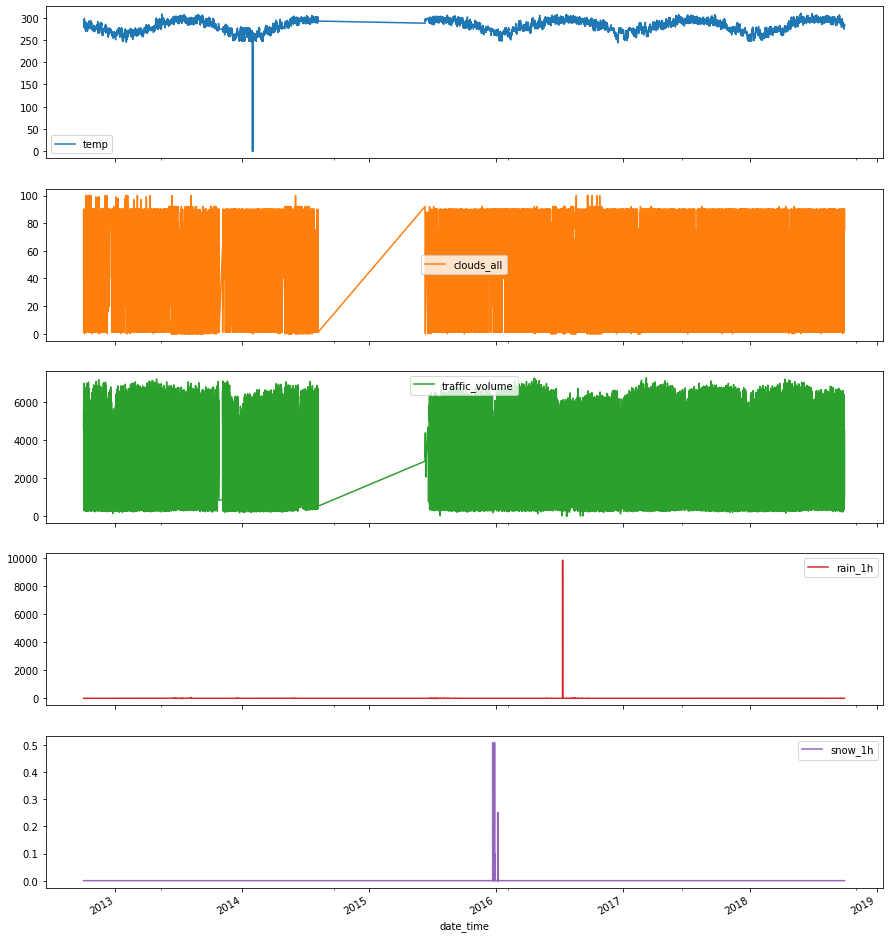

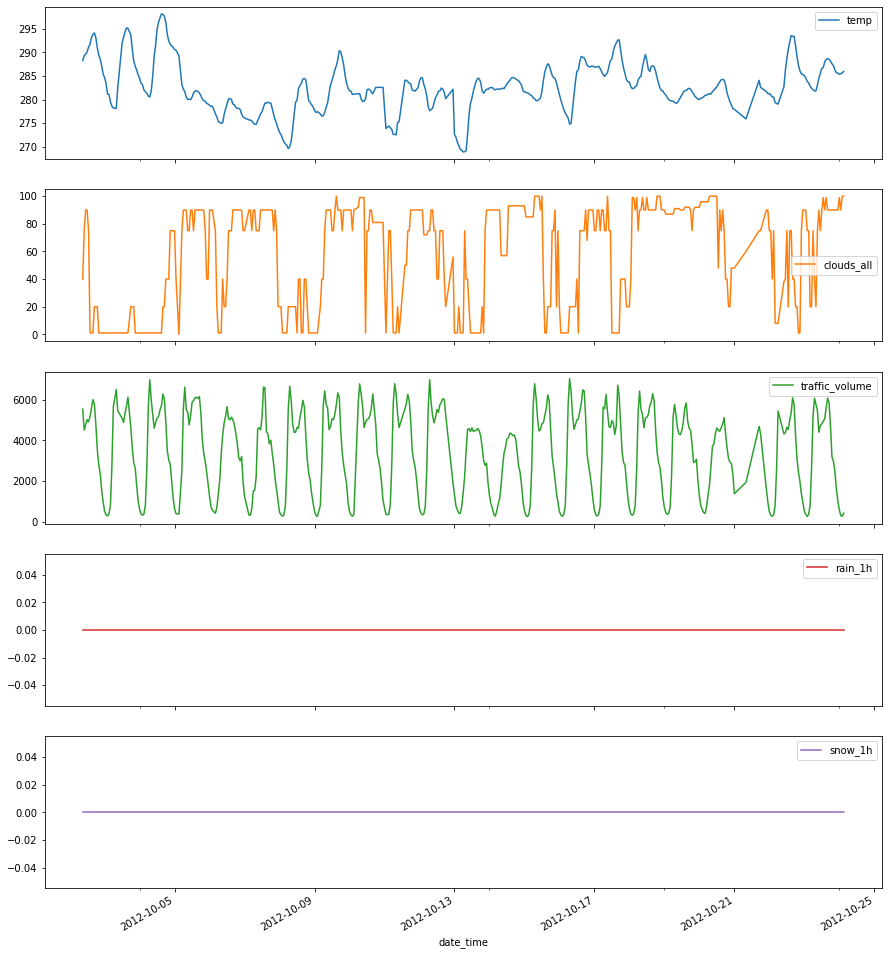

time: 4.11 s (started: 2022-06-08 22:18:17 +00:00)


In [14]:
# Selecting the fields of interest
subSelectedColumns = ['temp', 'clouds_all','traffic_volume', 'rain_1h', 'snow_1h']
plotFeatures = df_metro[subSelectedColumns]
plotFeatures.index = df_metro['date_time']
_ = plotFeatures.plot(subplots=True, figsize=(15,18))


# sub select the features of interest and create a sub set data frame with the first 480 records
plotFeatures = df_metro[subSelectedColumns][:480]
# reindex the data frame
plotFeatures.index = df_metro['date_time'][:480]
_ = plotFeatures.plot(subplots=True, figsize=(15,18))

derive the descriptive statistics for the multiple columns at the same time and transpose the result

In [15]:
df_metro.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,40575.0,281.316763,13.816618,0.0,271.84,282.86,292.28,310.07
rain_1h,40575.0,0.318632,48.812640,0.0,0.00,0.00,0.00,9831.30
snow_1h,40575.0,0.000117,0.005676,0.0,0.00,0.00,0.00,0.51
clouds_all,40575.0,44.199162,38.683447,0.0,1.00,40.00,90.00,100.00
traffic_volume,40575.0,3290.650474,1984.772909,0.0,1248.50,3427.00,4952.00,7280.00


time: 33.6 ms (started: 2022-06-08 22:18:21 +00:00)


* The mean temperature is 281.31 in Kelvin.
* The mean traffic volume 

### Preprocess the data

In [16]:
# unique values of the temp attribute values
df_metro['temp'].value_counts()

274.150    80
276.793    78
291.150    61
271.150    56
272.150    54
           ..
307.320     1
307.330     1
307.200     1
305.070     1
304.900     1
Name: temp, Length: 5841, dtype: int64

time: 8.55 ms (started: 2022-06-08 22:18:21 +00:00)


In [17]:
# unique values of each numerical attribute value
dfColumns=[]
for col in  df_metro.columns:
  dfColumns.append([col, df_metro[col].nunique(), df_metro[col].drop_duplicates().values])
pd.DataFrame(dfColumns, columns=['Features', 'Unique Number', 'Values'])

,Features,Unique Number,Values
0,holiday,12,"[None, Columbus Day, Veterans Day, Thanksgivin..."
1,temp,5841,"[288.28, 289.36, 289.58, 290.13, 291.14, 291.7..."
2,rain_1h,372,"[0.0, 0.25, 0.57, 0.38, 0.3, 0.29, 0.44, 0.36,..."
3,snow_1h,12,"[0.0, 0.51, 0.32, 0.06, 0.05, 0.21, 0.25, 0.44..."
4,clouds_all,60,"[40, 75, 90, 1, 20, 0, 100, 92, 99, 81, 50, 72..."
5,weather_main,11,"[Clouds, Clear, Rain, Drizzle, Mist, Fog, Thun..."
6,weather_description,35,"[scattered clouds, broken clouds, overcast clo..."
7,date_time,40575,"[2012-10-02T09:00:00.000000000, 2012-10-02T10:..."
8,traffic_volume,6704,"[5545, 4516, 4767, 5026, 4918, 5181, 5584, 601..."


time: 47.3 ms (started: 2022-06-08 22:18:21 +00:00)


We see the unique values of each and everty column.

#### Drop all the Categorical variables

In [18]:
# Create numeric dataset with only numerical variables
df_trafficWeather = df_metro.drop(columns=['holiday',   'weather_main', 'weather_description', 'date_time'])

# reset the index of the data frame
# df_trafficWeather.set_index(['date_time'])
df_trafficWeather.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,288.28,0.0,0.0,40,5545
1,289.36,0.0,0.0,75,4516
2,289.58,0.0,0.0,90,4767
3,290.13,0.0,0.0,90,5026
4,291.14,0.0,0.0,75,4918


time: 11.9 ms (started: 2022-06-08 22:18:22 +00:00)


In [19]:
# look at the meta data of the dataframe
df_trafficWeather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40575 entries, 0 to 40574
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp            40575 non-null  float64
 1   rain_1h         40575 non-null  float64
 2   snow_1h         40575 non-null  float64
 3   clouds_all      40575 non-null  int64  
 4   traffic_volume  40575 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 1.5 MB
time: 8.45 ms (started: 2022-06-08 22:18:22 +00:00)


In [20]:
# shape of the data frame
df_trafficWeather.shape

(40575, 5)

time: 3.05 ms (started: 2022-06-08 22:18:22 +00:00)


In [21]:
# let's determine if there are any missing values
df_trafficWeather.isnull().sum()

temp              0
rain_1h           0
snow_1h           0
clouds_all        0
traffic_volume    0
dtype: int64

time: 9.26 ms (started: 2022-06-08 22:18:22 +00:00)


So, there are no missing values in our data frame.

#### Time
Lets convert the data time into seconds

In [22]:
timestamp_s = df_metro['date_time'].map(pd.Timestamp.timestamp)

time: 188 ms (started: 2022-06-08 22:18:22 +00:00)


To deal with periodicity, we create signals by using sine and consine transform transform:

In [23]:
day = 24 * 60 * 60
year = (365.2425) * day

df_trafficWeather['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_trafficWeather['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_trafficWeather['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_trafficWeather['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

time: 12.4 ms (started: 2022-06-08 22:18:22 +00:00)


Plotting the signals

Text(0.5, 1.0, 'Time of day signal')

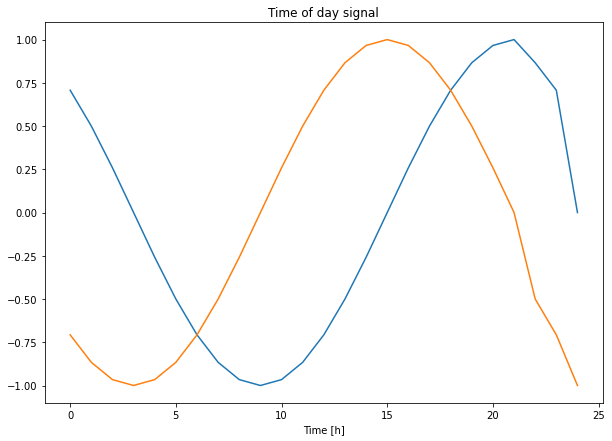

time: 210 ms (started: 2022-06-08 22:18:22 +00:00)


In [24]:
plt.figure(figsize=(10, 7))
plt.plot(np.array(df_trafficWeather['Day sin'][:25]))
plt.plot(np.array(df_trafficWeather['Day cos'][:25]))
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features.

Let's explore getting the tf.signal.rfft of the temperate over time.

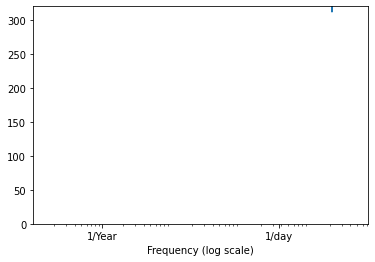

time: 4.41 s (started: 2022-06-08 22:18:22 +00:00)


In [25]:
fft = tf.signal.rfft(df_trafficWeather['traffic_volume'])
f_per_dataset = np.arange(0, len(fft))


# number of samples
n_samples_h = len(df_trafficWeather['traffic_volume'])
hoursPerYear = 24*365.2524
years_per_dataset = n_samples_h / (hoursPerYear)

f_per_year = f_per_dataset / years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 320)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_=plt.xlabel('Frequency (log scale)')

Here see the frequencies of the temp attribute in a given day

## Split the data set

create a dictionary of column indicies:

In [26]:
# create a dictionary of column indicies:
column_indices = {name: i for i, name in enumerate(df_trafficWeather.columns)}

time: 1.4 ms (started: 2022-06-08 22:18:26 +00:00)


split the data set

In [27]:
# first take off the 5000 from 
test_df = df_trafficWeather.iloc[-5000:]

n = (df_trafficWeather.shape[0] - 5000)

train_df = df_trafficWeather[0:int(n*0.7)]

val_df = df_trafficWeather[int(n*0.7):n]


num_features = df_trafficWeather.shape[1]

print('Training   set : %d' %train_df.shape[0])
print('validation set : %d' %val_df.shape[0])
print('Testing    set : %d' %test_df.shape[0])
print('-'*23)
print('Total          : %d' %(train_df.shape[0] + val_df.shape[0] + test_df.shape[0]))

# train_df.shape, val_df.shape, test_df.shape

Training   set : 24902
validation set : 10673
Testing    set : 5000
-----------------------
Total          : 40575
time: 6.57 ms (started: 2022-06-08 22:18:26 +00:00)


In [28]:
df_trafficWeather.shape

(40575, 9)

time: 7.54 ms (started: 2022-06-08 22:18:26 +00:00)


In [29]:
val_df.shape

(10673, 9)

time: 3.62 ms (started: 2022-06-08 22:18:26 +00:00)


In [30]:
test_df.shape

(5000, 9)

time: 3.21 ms (started: 2022-06-08 22:18:27 +00:00)


In [31]:
# shape train_df
train_df.shape

(24902, 9)

time: 4.22 ms (started: 2022-06-08 22:18:27 +00:00)


In [32]:
# shape of validation set
val_df.shape

(10673, 9)

time: 2.68 ms (started: 2022-06-08 22:18:27 +00:00)


In [33]:
# shape of the test set
test_df.shape

(5000, 9)

time: 4.09 ms (started: 2022-06-08 22:18:27 +00:00)


In [34]:
# df_trafficWeather.iloc[-5000:]

time: 456 µs (started: 2022-06-08 22:18:27 +00:00)


## Normalize the data sets.
Subtracting the mean and dividing by the standard deviation of each feature, we normalize the data sets. We use the simple average process to achieve this, where the mean and standard deviation should only be computed using the training data.This is done so that the the models have no access to the values in the validation and test sets.

In [35]:
# From TF Tutorial
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

time: 12.1 ms (started: 2022-06-08 22:18:27 +00:00)


let's look at the distribution of the features.

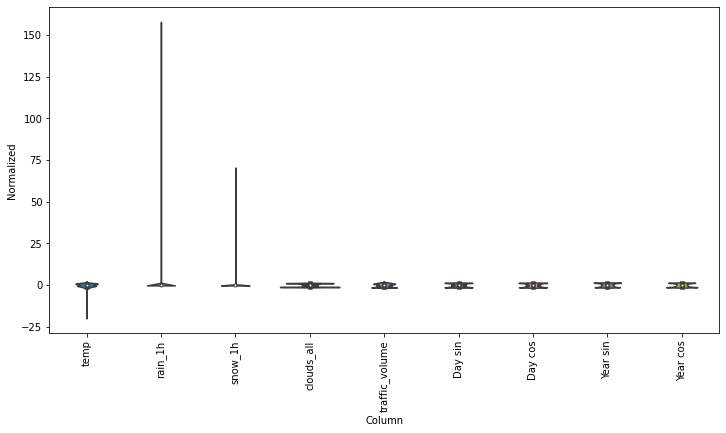

time: 1.34 s (started: 2022-06-08 22:18:27 +00:00)


In [36]:
df_trafficWeather_std  = (df_trafficWeather - train_mean) / train_std
df_trafficWeather_std = df_trafficWeather_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_trafficWeather_std)
_ = ax.set_xticklabels(df_trafficWeather.keys(), rotation=90)

Some features like rain_1h and snow_1h have long tails, which is an indication of having outliers within our data set.

## Data Windowing

### 1. Indexes and offsets From TF Tutorial




let's start by creating the WindowGenerator class

In [37]:
# From TF Tutorial
class WindowGenerator():
  """
  The main features of the input windows are:
  The width (number of time steps) of the input and label windows.
  The time offset between them.
  Which features are used as inputs, labels, or both.
  """
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    """
    This method includes all the necessary logic 
    for the input and label indicies
    """
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    print('input_width : %d' %self.input_width)
    self.label_width = label_width
    print('label_width : %d' %self.label_width)
    self.shift = shift
    print('shift: %d' %self.shift)

    self.total_window_size = input_width + shift
    print('total_window_size = input_width + shift : %d' %self.total_window_size)

    self.input_slice = slice(0, input_width) # slice a sequence
    print('input_slice : %s ' %str(self.input_slice))
    # retrieve five items from the numpy array
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]
    print('input_indices : %s' %str(self.input_indices))

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

time: 22.6 ms (started: 2022-06-08 22:18:28 +00:00)


The WindowGenerator class takes the training, validation, and test Dataframes as input. This class is used:
* to handle index and offsets as shown [here.](https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing)
* to split windows of features into (features, labels) pairs.
* to plot the content of the resulting windows.
* to effeciently generate batches of these windows.from the training, validation and test data, using tf.data.Datasets.

let's create the 2 windows examples 

In [38]:
# From TF Tutorial 
# Example 1 From TF Tutorial
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['traffic_volume'])
w1

input_width : 24
label_width : 1
shift: 24
total_window_size = input_width + shift : 48
input_slice : slice(0, 24, None) 
input_indices : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['traffic_volume']

time: 5.34 ms (started: 2022-06-08 22:18:28 +00:00)


In [39]:
# From TF Tutorial 
# Example 2 From TF Tutorial
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['traffic_volume'])
w2

input_width : 6
label_width : 1
shift: 1
total_window_size = input_width + shift : 7
input_slice : slice(0, 6, None) 
input_indices : [0 1 2 3 4 5]


Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['traffic_volume']

time: 6.25 ms (started: 2022-06-08 22:18:28 +00:00)


### 2. Split From TF Tutorial

let's define a split_window function that converts a list of consecutive inputs into a window of inputs and a window of labels.

In [40]:
# From TF Tutorial
def split_window(self, features):
  """
  Function that returns a window of inputs and a window of labels 
  that result from the conversion of a list consecutive inputs 
  """
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  # From TF Tutorial
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
  print('inputs: %s' %str(inputs))
  print('labels: %s' %str(labels))
  return inputs, labels

WindowGenerator.split_window = split_window

time: 12.1 ms (started: 2022-06-08 22:18:28 +00:00)


let's test the split_window function we just created:

In [41]:
# Stack three slices, the length of the total window From 
# From TF Tutorial
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

inputs: tf.Tensor(
[[[ 0.50522444 -0.00805614 -0.02638527 -0.14051537  1.14975523
    1.00483143 -1.01028253 -1.37952493  0.06942852]
  [ 0.58103259 -0.00805614 -0.02638527  0.77033262  0.63250984
    0.71122797 -1.23449596 -1.37950229  0.0704296 ]
  [ 0.59647499 -0.00805614 -0.02638527  1.16069604  0.75867951
    0.3693195  -1.37544242 -1.37947892  0.07143065]
  [ 0.63508099 -0.00805614 -0.02638527  1.16069604  0.88887053
    0.00240652 -1.42351663 -1.37945481  0.07243169]
  [ 0.70597564 -0.00805614 -0.02638527  0.77033262  0.83458238
   -0.36450646 -1.37544242 -1.37942996  0.07343272]
  [ 0.74668742 -0.00805614 -0.02638527 -1.15546026  0.96678407
   -0.70641493 -1.23449596 -1.37940438  0.07443372]]

 [[-0.20512596 -0.00805614 -0.02638527  1.16069604 -0.04910799
   -1.22530825  0.69278759 -1.37292599  0.1763503 ]
  [-0.22127028 -0.00805614 -0.02638527  1.16069604 -0.13355622
   -1.00001839  0.98498823 -1.3728246   0.17734675]
  [-0.29356879 -0.00805614 -0.02638527  1.16069604 -0.02799

The above code defines the processing of a 7-time step window with 9 attributes at each time step. A batch of 6 time step 9 features inputs and a 1-time step feature is derived through splitting. The WindowGenerator class was intialized with two features, which explains the reason why the label has just two features; if it was initialized with one feature, then the label would have one feature. 

### 3. Using the plot method to create the right windows. 
The inputs, labels and predictions based on time are aligned by this plot.

Let's start by creating the function.

In [42]:
# From TF Tutorial
# initializing an instance variable with inputs and labels vectors
w2.example = example_inputs, example_labels 

time: 1.27 ms (started: 2022-06-08 22:18:28 +00:00)


In [43]:
# From TF Tutorial
def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
  inputs, labels = self.example
  #print('shape of inputs: %s' %str(inputs.Shape))
  #print('shape of labels: %s' %str(labels.Shape))
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      #print('The size of the predictions: %s' %str(predictions.Shape))
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

time: 28 ms (started: 2022-06-08 22:18:28 +00:00)


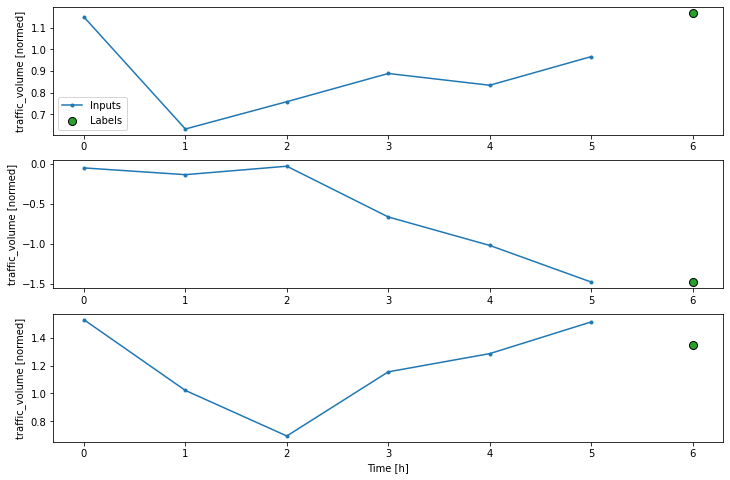

time: 472 ms (started: 2022-06-08 22:18:28 +00:00)


In [44]:
# plotting the traffic_volume
w2.plot(plot_col='traffic_volume')

### 4. Convert a time series DataFrame into pairs of input_window and label_window, (input_window, label_window).

start by creating a function:

In [45]:
# From TF Tutorial
def make_dataset(self, data):
  """
  Return a dataset of (input_window, label_window) pairs
  """
  data = np.array(data, dtype=np.float32)
  ds = timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False, # turn off the default shuffling
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

time: 4.25 ms (started: 2022-06-08 22:18:29 +00:00)


adding properties to access training, validation and test data set through the make_dataset defined method:

In [46]:
@property
def train(self):
  """access the training data set through the make_dataset method"""
  shuffle=True                          # shuffle the training set
  return self.make_dataset(self.train_df)

@property
def val(self):
  """access the validation data set through the make_dataset method"""
  shuffle = False
  return self.make_dataset(self.val_df)

@property
def test(self):
  """access the test data set through the make_dataset method"""
  shuffle=False
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

time: 12.6 ms (started: 2022-06-08 22:18:29 +00:00)


let's look at the structure, data types  and shapes of the dataset elements. I would call this the meta data.

In [47]:
# From TF Tutorial
w2.train.element_spec

inputs: Tensor("strided_slice:0", shape=(None, 6, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)


(TensorSpec(shape=(None, 6, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

time: 180 ms (started: 2022-06-08 22:18:29 +00:00)


let's yield concrete batches:

In [48]:
# From TF Tutorial
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

inputs: Tensor("strided_slice:0", shape=(None, 6, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)
Inputs shape (batch, time, features): (32, 6, 9)
Labels shape (batch, time, features): (32, 1, 1)
time: 177 ms (started: 2022-06-08 22:18:29 +00:00)


## Simple - Single step models
Models that predict single feature(s) values.

Instantiate a WindowGenerator object to derive the single-step (input, label) pairs which creates an iterator object that access the individuals inputs and labels.

In [49]:
# From TF Tutorial
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['traffic_volume'])
single_step_window

input_width : 1
label_width : 1
shift: 1
total_window_size = input_width + shift : 2
input_slice : slice(0, 1, None) 
input_indices : [0]


Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['traffic_volume']

time: 7.94 ms (started: 2022-06-08 22:18:29 +00:00)


Loop through the batches of data of the WindowGenerator object:

In [50]:
# From TF Tutorial
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

inputs: Tensor("strided_slice:0", shape=(None, 1, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)
Inputs shape (batch, time, features): (32, 1, 9)
Labels shape (batch, time, features): (32, 1, 1)
time: 96.2 ms (started: 2022-06-08 22:18:29 +00:00)


### Performance BaseLine model
This will act as a baseline model to be compared with later more complicated models.

Our goal is to predict traffic volume into the future, given the current value of all features. 

First, we create a Baseline class:

In [51]:
# From TF Tutorial
class Baseline(tf.keras.Model):
  """fowards the input to the output"""
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

time: 3.12 ms (started: 2022-06-08 22:18:29 +00:00)


Instantiate and validate the model:

In [52]:
# From TF Tutorial
baseline = Baseline(label_index=column_indices['traffic_volume'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

inputs: Tensor("strided_slice:0", shape=(None, 1, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)
334/334 [==============================] - 1s 2ms/step - loss: 0.1743 - mean_absolute_error: 0.2976
inputs: Tensor("strided_slice:0", shape=(None, 1, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)
time: 1.93 s (started: 2022-06-08 22:18:29 +00:00)


let's create a WindowGenerator object, which derives windows 24 hours of consecutive inputs and labels at a time.

In [53]:
# From TF Tutorial
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['traffic_volume'])

wide_window

input_width : 24
label_width : 24
shift: 1
total_window_size = input_width + shift : 25
input_slice : slice(0, 24, None) 
input_indices : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['traffic_volume']

time: 6.14 ms (started: 2022-06-08 22:18:31 +00:00)


The inputs and outputs have the same number of time steps and we use the Baseline object,baseline, to forward the inputs to the outputs:

In [54]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

inputs: Tensor("strided_slice:0", shape=(None, 24, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 24, 1), dtype=float32)
Input shape: (32, 24, 9)
Output shape: (32, 24, 1)
time: 75.9 ms (started: 2022-06-08 22:18:31 +00:00)


Plot the Baseline's object (baseline) model's predictions:

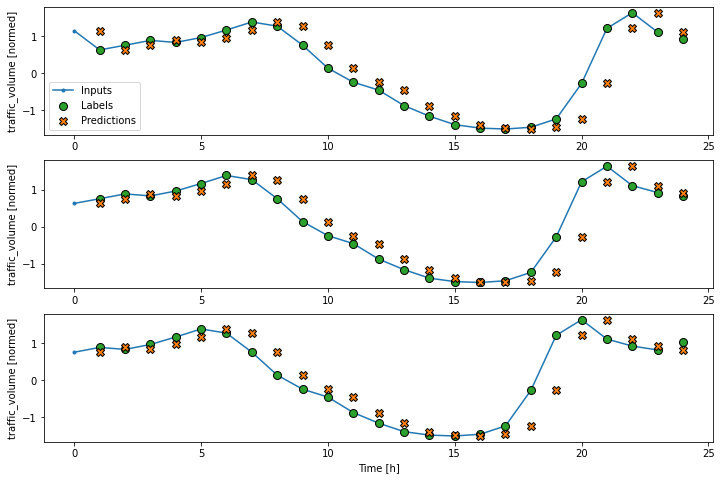

time: 465 ms (started: 2022-06-08 22:18:31 +00:00)


In [55]:
# From TF Tutorial
wide_window.plot(baseline)

As shown above, a single step model is run over the course of 24 hours and the plot shows three graphs where:
* the plot shows the traffic volume with the a blue input line that show the input traffic volume at each step.
* the green dots are displayed at prediction time.
* the orange Predictions crosses are the model's predictions for each output time step. The predictions would land directly on the labels if the model was a perfect model predicting perfectly. # From TF Tutorial.

### Linear model
Without any activations, let's insert a linear transformation in between the input and output. 

In [56]:
# Without inserting any activations,
# this layer transforms the last axis of data from (batch, time, inputs) to (batch, time, units)
# From TF Tutorial
linear_model = Sequential([
                     layers.Dense(units=1)
])

time: 9.62 ms (started: 2022-06-08 22:18:32 +00:00)


In [57]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear_model(single_step_window.example[0]).shape)

inputs: Tensor("strided_slice:0", shape=(None, 1, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)
Input shape: (32, 1, 9)
Output shape: (32, 1, 1)
time: 1.92 s (started: 2022-06-08 22:18:32 +00:00)


helper function that compiles and fits the training data to the network model.

In [58]:
EPOCHS = 20

def compileAndFit(model, window, patience=2):
  """
  Function that returns the model's history after compiling 
  and fitting the training data to the model
  """
  early_stopping = EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  # compile the model
  model.compile(loss=MeanSquaredError(),
                optimizer=Adam(),
                metrics=[MeanAbsoluteError()])
  # fit the data with with the network model
  history = model.fit(window.train, epochs=EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

time: 3.49 ms (started: 2022-06-08 22:18:34 +00:00)


Invoke the compileAndFit function to compile, and fit the training data with the model and evaluate its performance:

In [59]:
# a helper function that returns the model's history after compiling 
# and fitting the training to the model.
history = compileAndFit(linear_model, single_step_window)

val_performance['Linear'] = linear_model.evaluate(single_step_window.val)
performance['Linear'] = linear_model.evaluate(single_step_window.test, verbose=0)

inputs: Tensor("strided_slice:0", shape=(None, 1, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)
inputs: Tensor("strided_slice:0", shape=(None, 1, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)
Epoch 1/20
779/779 [==============================] - 4s 3ms/step - loss: 1.9577 - mean_absolute_error: 1.1716 - val_loss: 0.6034 - val_mean_absolute_error: 0.6728
Epoch 2/20
779/779 [==============================] - 3s 4ms/step - loss: 0.3596 - mean_absolute_error: 0.4479 - val_loss: 0.1480 - val_mean_absolute_error: 0.2932
Epoch 3/20
779/779 [==============================] - 3s 3ms/step - loss: 0.1930 - mean_absolute_error: 0.2942 - val_loss: 0.1271 - val_mean_absolute_error: 0.2601
Epoch 4/20
779/779 [==============================] - 3s 3ms/step - loss: 0.1730 - mean_absolute_error: 0.2809 - val_loss: 0.1236 - val_mean_absolute_error: 0.2553
Epoch 5/20
779/779 [==============================] - 3s 4ms/step - loss: 0.1626 - m

In [60]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)
time: 2.73 ms (started: 2022-06-08 22:19:19 +00:00)


Plotting of predictions on the wide_window:

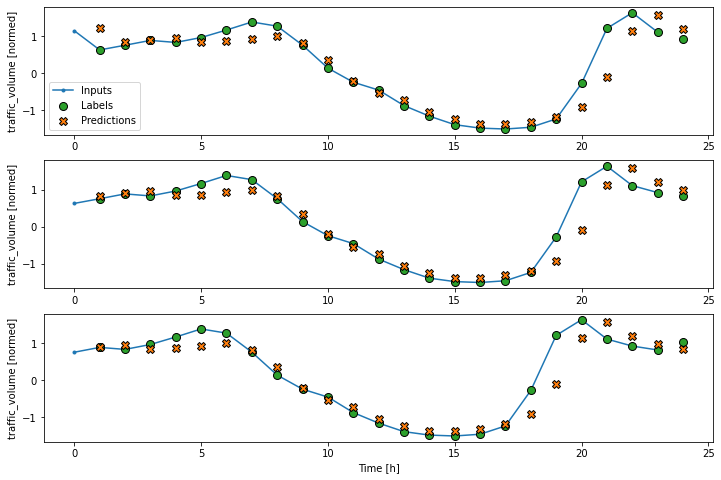

time: 457 ms (started: 2022-06-08 22:19:19 +00:00)


In [61]:
wide_window.plot(linear_model)

Visualize the layer's weights and see how they are assigned to each input:

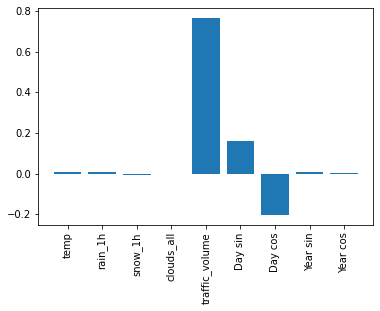

time: 145 ms (started: 2022-06-08 22:19:19 +00:00)


In [62]:
# From TF Tutorial
plt.bar(x = range(len(train_df.columns)),
        height=linear_model.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

It is surprising how Day sin carries more weight than traffic volume since the linear model does not place the most weight on it. 

### Linear Dense model
Where we stack a few dense layers between the input the output:

In [63]:
# create the network
linearDense = Sequential([
                          layers.Dense(units=64, activation='relu'),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dense(units=1)
])
# compile and fit the training data to the model
history = compileAndFit(linearDense, single_step_window)

# model evaluation 
val_performance['Dense'] = linearDense.evaluate(single_step_window.val)
performance['Dense'] = linearDense.evaluate(single_step_window.test, verbose=0)

inputs: Tensor("strided_slice:0", shape=(None, 1, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)
inputs: Tensor("strided_slice:0", shape=(None, 1, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)
Epoch 1/20
779/779 [==============================] - 4s 5ms/step - loss: 0.1227 - mean_absolute_error: 0.2292 - val_loss: 0.1989 - val_mean_absolute_error: 0.3330
Epoch 2/20
779/779 [==============================] - 3s 4ms/step - loss: 0.3025 - mean_absolute_error: 0.1860 - val_loss: 0.1246 - val_mean_absolute_error: 0.2717
Epoch 3/20
779/779 [==============================] - 3s 4ms/step - loss: 0.1148 - mean_absolute_error: 0.1744 - val_loss: 0.1345 - val_mean_absolute_error: 0.2857
Epoch 4/20
779/779 [==============================] - 4s 5ms/step - loss: 0.0909 - mean_absolute_error: 0.1658 - val_loss: 0.0819 - val_mean_absolute_error: 0.2203
Epoch 5/20
779/779 [==============================] - 3s 4ms/step - loss: 0.0848 - m

### Need to see how the input features are changing: 

through **Multi-step dense** where multiple time steps are taken as input to produce a single output.

let's instantiate a WindowGenerator object which will generate batches of three-hour inputs and one hour labels:

In [64]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['traffic_volume'])

conv_window

input_width : 3
label_width : 1
shift: 1
total_window_size = input_width + shift : 4
input_slice : slice(0, 3, None) 
input_indices : [0 1 2]


Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['traffic_volume']

time: 6.42 ms (started: 2022-06-08 22:19:46 +00:00)


We see multiple time steps and a single output.

Plottings of the predictions.

inputs: Tensor("strided_slice:0", shape=(None, 3, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)


Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

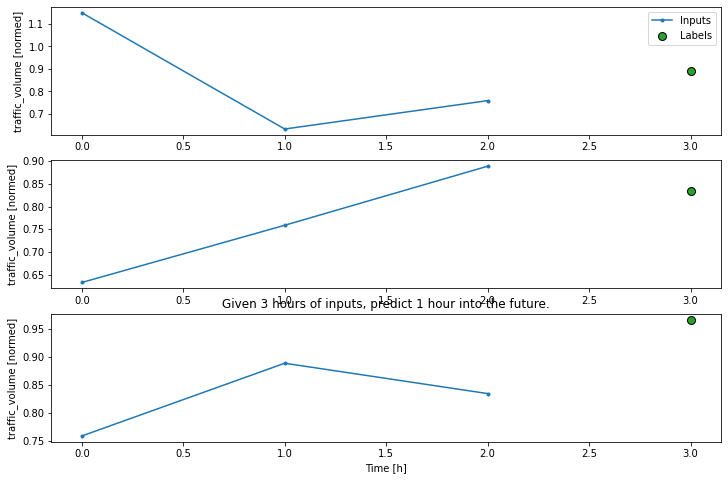

time: 529 ms (started: 2022-06-08 22:19:46 +00:00)


In [65]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

Adding Flatten from the Keras.layers as the first layer of the model to train a dense model on a multiple-input-step window:

In [66]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    layers.Flatten(),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    layers.Reshape([1, -1]),
])

time: 10.8 ms (started: 2022-06-08 22:19:47 +00:00)


In [67]:
# Explain the output
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 9)
Output shape: (32, 1, 1)
time: 39.9 ms (started: 2022-06-08 22:19:47 +00:00)


Compile and fit the training data to the model and evaluate it:

In [68]:
history = compileAndFit(multi_step_dense, conv_window)

IPython.display.clear_output() # clears the window
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

inputs: Tensor("strided_slice:0", shape=(None, 3, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)
334/334 [==============================] - 1s 2ms/step - loss: 0.0677 - mean_absolute_error: 0.2004
inputs: Tensor("strided_slice:0", shape=(None, 3, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)
time: 24.9 s (started: 2022-06-08 22:19:47 +00:00)


Plotting the predictions

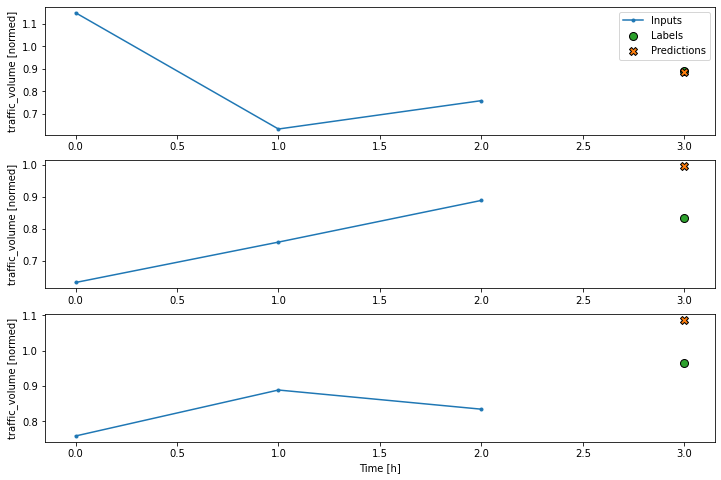

time: 453 ms (started: 2022-06-08 22:20:12 +00:00)


In [69]:
conv_window.plot(multi_step_dense)

### Convolution neural network (CNN)
Since it sees how things change over time, CNN perfroms better than the dense model.

In [70]:
# From TF Tutorial
conv_model = tf.keras.Sequential([
    layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=1),
])

time: 8.28 ms (started: 2022-06-08 22:20:12 +00:00)


To confirm whether the model produces outputs with the expected shape, we run the Convolution model we just created on a batch example.

In [71]:
# From TF Tutorial
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 9)
Output shape: (32, 1, 1)
time: 45 ms (started: 2022-06-08 22:20:12 +00:00)


We compile, train, and evaluate the Convolution model on the conv_window and we see similar results to the multi_step_dense model:

In [72]:
history = compileAndFit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

inputs: Tensor("strided_slice:0", shape=(None, 3, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)
334/334 [==============================] - 1s 3ms/step - loss: 0.0560 - mean_absolute_error: 0.1733
inputs: Tensor("strided_slice:0", shape=(None, 3, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)
time: 34.3 s (started: 2022-06-08 22:20:12 +00:00)


CNN uses multiple time steps as input to each prediction and can also be run on inputs of any length 

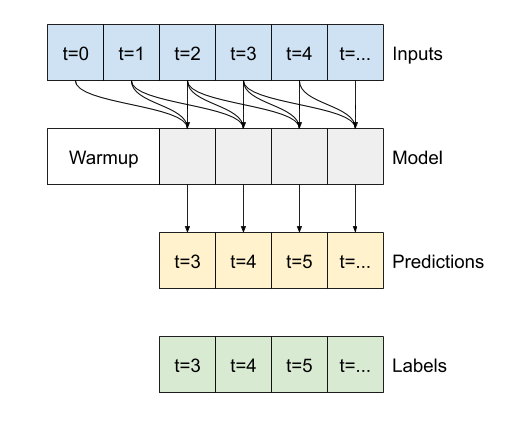

Running it on a wider input, it produces a wider output as shown below:

In [73]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 9)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)
time: 47.5 ms (started: 2022-06-08 22:20:47 +00:00)


The output's length above differs from the input.

The labels and prediction need to have the same length in order for training and plotting to work. In order for the lengths of the both the **label** and **prediction** to match,  we instantiate a **WindowGenerator** to generate wide windows with a few extra input time steps:

In [74]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['traffic_volume'])

wide_conv_window

input_width : 26
label_width : 24
shift: 1
total_window_size = input_width + shift : 27
input_slice : slice(0, 26, None) 
input_indices : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['traffic_volume']

time: 5.56 ms (started: 2022-06-08 22:20:47 +00:00)


In [75]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
inputs: Tensor("strided_slice:0", shape=(None, 26, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 24, 1), dtype=float32)
Input shape: (32, 26, 9)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)
time: 83.3 ms (started: 2022-06-08 22:20:47 +00:00)


We observe that the output's length is the same as the input.

Plot the model's predictions.

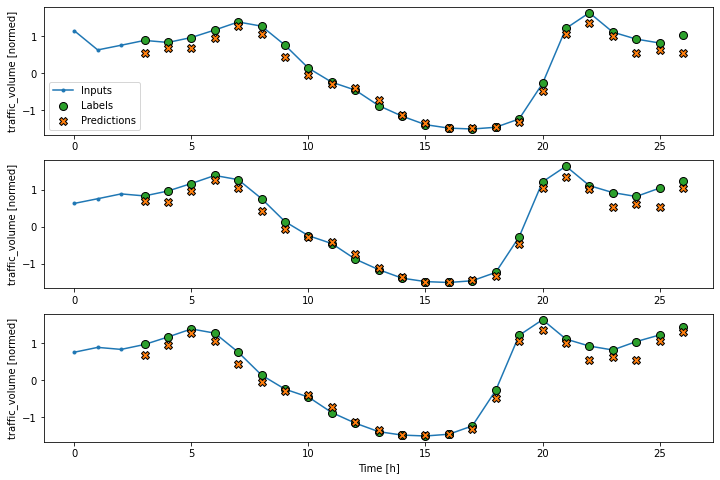

time: 441 ms (started: 2022-06-08 22:20:47 +00:00)


In [76]:
wide_conv_window.plot(conv_model)

Every prediction is based on the 3 preceding time steps.

### Recurrent neural network
A type of neural network well-suited for time-series data.

The return_sequence argument in the LSTM constructor can be configured into two ways:

* returns the output of the final time step if configured with the False boolean value:
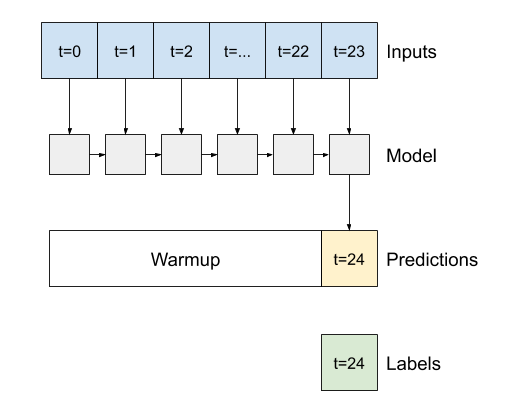

* returns an output for each input if configured a True boolean value and it is beneficial when you are stacling RNN layers and training a model on multiple time steps simultaneously:

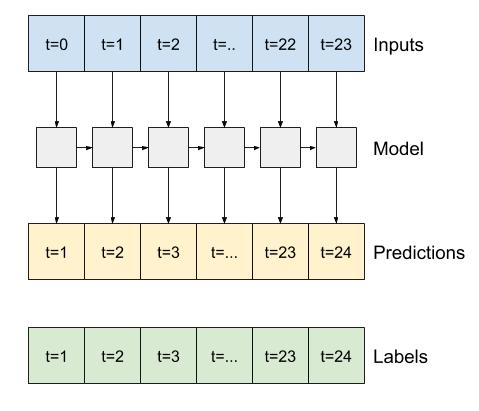

Create an LSTM model:

In [77]:
lstm_model = Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    # return_sequence=True means the model can be trained on 24 hours of data at a time.
    layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    layers.Dense(units=1)
])

time: 10.8 ms (started: 2022-06-08 22:20:47 +00:00)


In [78]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)
time: 1.03 s (started: 2022-06-08 22:20:47 +00:00)


Compile, train the LSTM model on the train and evaluate it:

In [79]:
history = compileAndFit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

inputs: Tensor("strided_slice:0", shape=(None, 24, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 24, 1), dtype=float32)
333/333 [==============================] - 1s 3ms/step - loss: 0.0242 - mean_absolute_error: 0.1055
inputs: Tensor("strided_slice:0", shape=(None, 24, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 24, 1), dtype=float32)
time: 1min 34s (started: 2022-06-08 22:20:48 +00:00)


Plotting of model's prediction on the wide_window.

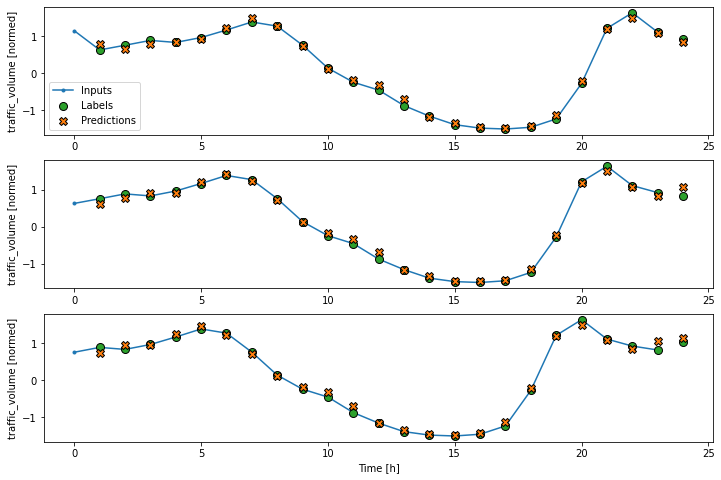

time: 443 ms (started: 2022-06-08 22:22:23 +00:00)


In [80]:
wide_window.plot(lstm_model)

let's look at the performance of the LSTM model comparing it to other models. 

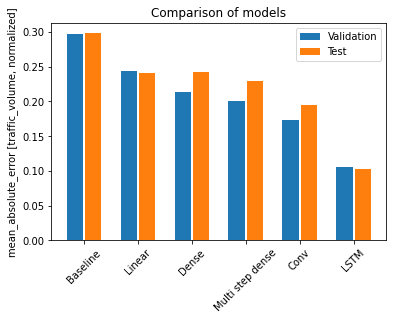

time: 182 ms (started: 2022-06-08 22:22:23 +00:00)


In [81]:

x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [traffic_volume, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.title('Comparison of models')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

We see that each model's performance is slighly better than the other.

### Basic_lstm_model

In [82]:
# build the basic lstm model
basic_lstm_model = Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    # return_sequence=True means the model can be trained on 24 hours of data at a time.
    layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    layers.Dense(units=1)
])

time: 7.54 ms (started: 2022-06-08 22:22:24 +00:00)


Let's create a WindowGenerator object, window_5_1_2

In [83]:
# create a WindowGenerator object
window_5_1_2 = WindowGenerator(input_width=5, label_width=1, shift=2, label_columns=['traffic_volume'])
window_5_1_2

input_width : 5
label_width : 1
shift: 2
total_window_size = input_width + shift : 7
input_slice : slice(0, 5, None) 
input_indices : [0 1 2 3 4]


Total window size: 7
Input indices: [0 1 2 3 4]
Label indices: [6]
Label column name(s): ['traffic_volume']

time: 4.67 ms (started: 2022-06-08 22:22:24 +00:00)


inputs: Tensor("strided_slice:0", shape=(None, 5, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)


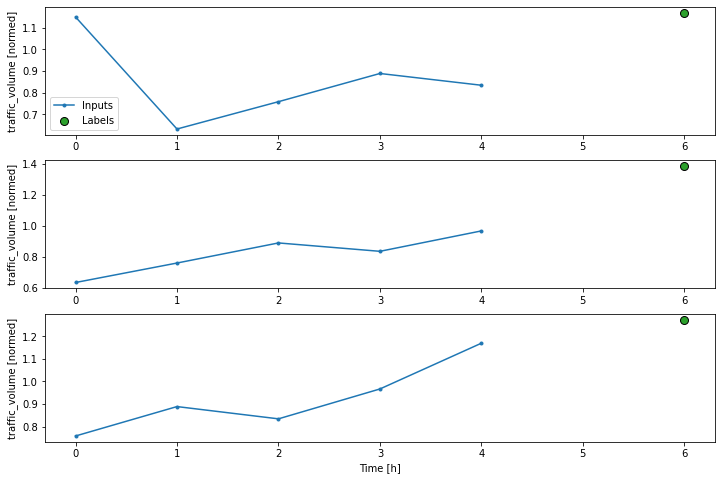

time: 503 ms (started: 2022-06-08 22:22:24 +00:00)


In [84]:
# plot the window sizes
window_5_1_2.plot()

In [85]:
for example_inputs, example_labels in window_5_1_2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

inputs: Tensor("strided_slice:0", shape=(None, 5, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)
Inputs shape (batch, time, features): (32, 5, 9)
Labels shape (batch, time, features): (32, 1, 1)
time: 71.9 ms (started: 2022-06-08 22:22:24 +00:00)


Compile, train the LSTM model on the train and evaluate it:

In [86]:
history = compileAndFit(basic_lstm_model, window_5_1_2)

IPython.display.clear_output()
val_performance['LSTM'] = basic_lstm_model.evaluate(window_5_1_2.val)
performance['LSTM'] = basic_lstm_model.evaluate(window_5_1_2.test, verbose=0)

inputs: Tensor("strided_slice:0", shape=(None, 5, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)
334/334 [==============================] - 1s 3ms/step - loss: 0.1473 - mean_absolute_error: 0.2706
inputs: Tensor("strided_slice:0", shape=(None, 5, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)
time: 1min 22s (started: 2022-06-08 22:22:24 +00:00)


In [87]:
# model summary
basic_lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 5, 32)             5376      
                                                                 
 dense_10 (Dense)            (None, 5, 1)              33        
                                                                 
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
_________________________________________________________________
time: 20.2 ms (started: 2022-06-08 22:23:46 +00:00)


In [88]:
print('Input shape:', window_5_1_2.example[0].shape)
print('Output shape:', basic_lstm_model(window_5_1_2.example[0]).shape)

Input shape: (32, 5, 9)
Output shape: (32, 5, 1)
time: 14.6 ms (started: 2022-06-08 22:23:47 +00:00)


plot the model's predictions

In [89]:
#window_5_1_2.plot(basic_lstm_model)

time: 543 µs (started: 2022-06-08 22:23:47 +00:00)


#### derive the predictions

In [90]:
# pass the testing the data set from the WindowGeneratotr object as input parameter 
# to the predict function of the model, basic_lstm_model
prediction_res = basic_lstm_model.predict(window_5_1_2.test)

inputs: Tensor("strided_slice:0", shape=(None, 5, 9), dtype=float32)
labels: Tensor("stack:0", shape=(None, 1, 1), dtype=float32)
time: 795 ms (started: 2022-06-08 22:23:47 +00:00)


In [91]:
# shape of prediction_res
prediction_res.shape

(4994, 5, 1)

time: 3.33 ms (started: 2022-06-08 22:23:47 +00:00)


#### Denormalize the predictions
Since we have train_std and train_mean, we use the helper function, denormalizePredictions, to denormalize the predictions.

In [92]:
pred_L = []
for i in range(prediction_res.shape[0]):
  

  # res = y1[i][0] * train_std + train_mean
  res = denormalizePredictions(prediction_res[i][0], train_mean, train_std)
  pred_L.append(res)

time: 1.39 s (started: 2022-06-08 22:23:47 +00:00)


let's look at the type of the first item in the list:

In [93]:
type(pred_L[0])

pandas.core.series.Series

time: 2.87 ms (started: 2022-06-08 22:23:49 +00:00)


It's a panda series, so we convert a list of panda series into dataframe:

In [94]:
predictions_df = pd.concat(pred_L, axis=1).T

time: 204 ms (started: 2022-06-08 22:23:49 +00:00)


In [95]:
# the top 5 records
predictions_df.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,Day sin,Day cos,Year sin,Year cos
0,284.319184,14.658471,0.001837,54.129883,3709.690689,0.158571,0.170002,0.119567,0.134584
1,291.591519,46.464281,0.005535,73.744876,4725.201999,0.518651,0.531811,0.475184,0.499995
2,293.173165,53.381664,0.006340,78.010902,4946.063531,0.596965,0.610500,0.552527,0.579468
3,291.332334,45.330728,0.005403,73.045801,4689.009349,0.505818,0.518916,0.462510,0.486972
4,288.468675,32.806417,0.003947,65.321921,4289.127090,0.364028,0.376445,0.322477,0.343082


time: 11.3 ms (started: 2022-06-08 22:23:49 +00:00)


In [96]:
# last 5 records
predictions_df.tail()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,Day sin,Day cos,Year sin,Year cos
4989,280.838064,-0.566326,0.000067,44.740583,3223.585998,-0.013792,-0.003188,-0.050660,-0.040332
4990,275.684818,-23.104224,-0.002554,30.841213,2503.985064,-0.268948,-0.259569,-0.302653,-0.299266
4991,272.662323,-36.323212,-0.004091,22.688918,2081.922823,-0.418603,-0.409943,-0.450453,-0.451137
4992,270.086600,-47.588227,-0.005400,15.741660,1722.247978,-0.546136,-0.538089,-0.576406,-0.580558
4993,267.388300,-59.389335,-0.006772,8.463787,1345.456489,-0.679739,-0.672333,-0.708353,-0.716140


time: 10.9 ms (started: 2022-06-08 22:23:49 +00:00)


Reset the index of the predictions data frame:

In [97]:
start = 1
end = predictions_df.shape[0]
predictions_df.index = np.arange(start, end + 1)

time: 1.47 ms (started: 2022-06-08 22:23:49 +00:00)


In [98]:
# first 5 records of the data frame
predictions_df.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,Day sin,Day cos,Year sin,Year cos
1,284.319184,14.658471,0.001837,54.129883,3709.690689,0.158571,0.170002,0.119567,0.134584
2,291.591519,46.464281,0.005535,73.744876,4725.201999,0.518651,0.531811,0.475184,0.499995
3,293.173165,53.381664,0.006340,78.010902,4946.063531,0.596965,0.610500,0.552527,0.579468
4,291.332334,45.330728,0.005403,73.045801,4689.009349,0.505818,0.518916,0.462510,0.486972
5,288.468675,32.806417,0.003947,65.321921,4289.127090,0.364028,0.376445,0.322477,0.343082


time: 11.2 ms (started: 2022-06-08 22:23:49 +00:00)


In [99]:
# last five records of the data frame
predictions_df.tail()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,Day sin,Day cos,Year sin,Year cos
4990,280.838064,-0.566326,0.000067,44.740583,3223.585998,-0.013792,-0.003188,-0.050660,-0.040332
4991,275.684818,-23.104224,-0.002554,30.841213,2503.985064,-0.268948,-0.259569,-0.302653,-0.299266
4992,272.662323,-36.323212,-0.004091,22.688918,2081.922823,-0.418603,-0.409943,-0.450453,-0.451137
4993,270.086600,-47.588227,-0.005400,15.741660,1722.247978,-0.546136,-0.538089,-0.576406,-0.580558
4994,267.388300,-59.389335,-0.006772,8.463787,1345.456489,-0.679739,-0.672333,-0.708353,-0.716140


time: 10.1 ms (started: 2022-06-08 22:23:49 +00:00)


This justifies that the index has been reset.

Let's extract out the **predicted traffic volume**:

In [100]:
# create a new data frame by creating a copy of the prediction data frame with only the traffic column
predicted_traffic_volume_df = predictions_df[['traffic_volume']].copy()

time: 1.46 ms (started: 2022-06-08 22:23:49 +00:00)


In [101]:
# rename the index to id
predicted_traffic_volume_df.index.names = ['id']

time: 1.18 ms (started: 2022-06-08 22:23:49 +00:00)


In [102]:
# rename the traffic column to predictions
predicted_traffic_volume_df.rename(columns={'traffic_volume':'prediction'}, inplace=True)

time: 1.16 ms (started: 2022-06-08 22:23:49 +00:00)


In [103]:
# first five records
predicted_traffic_volume_df.head()

,prediction
id,
1,3709.690689
2,4725.201999
3,4946.063531
4,4689.009349
5,4289.127090


time: 5.6 ms (started: 2022-06-08 22:23:49 +00:00)


#### Write the predictions a csv file:

In [104]:
# write predicted_traffic_volume_df to a csv file
predicted_traffic_volume_df.to_csv('predictions.csv', index=True, sep=',')

time: 403 ms (started: 2022-06-08 22:23:49 +00:00)


#### Visualizing the performance of the basic_lstm_model:

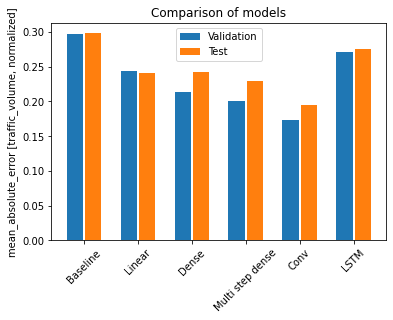

time: 173 ms (started: 2022-06-08 22:23:49 +00:00)


In [105]:
visualizePerformance(basic_lstm_model, performance, val_performance)

We see the basic_lstm_model performs pretty much the same way as the Baseline model. 